In [16]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import string
from scipy import stats
from tqdm import tqdm

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Create directories
ASSETS_DIR = "../preProcessingTechnique02/assets"
PROCESSED_DIR = "./processed_datasets"
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
print(f"All assets will be saved in {ASSETS_DIR}")
print(f"All processed datasets will be saved in {PROCESSED_DIR}")

def get_asset_path(filename):
    return os.path.join(ASSETS_DIR, filename)

All assets will be saved in ../preProcessingTechnique02/assets
All processed datasets will be saved in ./processed_datasets


In [17]:
def load_dataset(file_path):
    """Load passwords from file with automatic format detection"""
    file_name = os.path.basename(file_path)
    
    try:
        if file_path.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                passwords = [line.strip() for line in f if line.strip()]
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            password_col = 'password' if 'password' in df.columns else df.columns[0]
            passwords = df[password_col].dropna().tolist()
        else:
            raise ValueError(f"Unsupported file format: {file_path}")
            
        print(f"Loaded {len(passwords):,} passwords from {file_name}")
        return passwords, file_name
        
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return [], file_name

In [18]:
def analyze_dataset(passwords, name, max_length=15, verbose=True):
    """Analyze a password dataset"""
    # Count total passwords
    total_count = len(passwords)
    
    # Filter by length
    filtered_passwords = [pwd for pwd in passwords if len(pwd) <= max_length]
    filtered_count = len(filtered_passwords)
    
    # Handle empty dataset after filtering
    if filtered_count == 0:
        if verbose:
            print(f"No passwords remain in {name} after filtering to ≤{max_length} chars")
        return None
        
    # Calculate length statistics
    lengths = [len(pwd) for pwd in filtered_passwords]
    length_counts = Counter(lengths)
    
    # Categorize passwords
    categories = {
        'alpha_lower': 0,  # Only lowercase letters
        'alpha_mixed': 0,  # Mixed case letters
        'only_numeric': 0, # Only numbers
        'only_special': 0, # Only special chars
        'alphanumeric': 0, # Letters and numbers
        'complex': 0       # Letters, numbers, and special
    }
    
    for pwd in filtered_passwords:
        has_lower = bool(re.search(r'[a-z]', pwd))
        has_upper = bool(re.search(r'[A-Z]', pwd))
        has_digit = bool(re.search(r'[0-9]', pwd))
        has_special = bool(re.search(r'[^a-zA-Z0-9]', pwd))
        
        if has_lower and not has_upper and not has_digit and not has_special:
            categories['alpha_lower'] += 1
        elif (has_lower or has_upper) and not has_digit and not has_special:
            categories['alpha_mixed'] += 1
        elif not has_lower and not has_upper and has_digit and not has_special:
            categories['only_numeric'] += 1
        elif not has_lower and not has_upper and not has_digit and has_special:
            categories['only_special'] += 1
        elif (has_lower or has_upper) and has_digit and not has_special:
            categories['alphanumeric'] += 1
        else:
            categories['complex'] += 1
    
    # Calculate percentages
    categories_pct = {k: 100 * v / filtered_count for k, v in categories.items()}
    
    # Build stats dictionary
    stats = {
        'total': total_count,
        'filtered': filtered_count,
        'filter_pct': 100 * filtered_count / total_count if total_count > 0 else 0,
        'excluded': total_count - filtered_count,
        'avg_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'std_length': np.std(lengths),
        'min_length': min(lengths),
        'max_length': max(lengths),
        'length_counts': length_counts,
        'categories': categories,
        'categories_pct': categories_pct
    }
    
    if verbose:
        print_dataset_stats(name, stats, max_length)
        
    return stats

In [19]:
def print_dataset_stats(name, stats, max_length):
    """Print statistics for a dataset"""
    print(f"\n=== Dataset: {name} ===")
    print(f"Total passwords: {stats['total']:,}")
    print(f"Passwords ≤{max_length} chars: {stats['filtered']:,} ({stats['filter_pct']:.1f}%)")
    print(f"Excluded: {stats['excluded']:,}")
    print(f"\nLength statistics:")
    print(f"  Average: {stats['avg_length']:.2f} chars")
    print(f"  Median: {stats['median_length']:.1f} chars")
    print(f"  Std Dev: {stats['std_length']:.2f}")
    print(f"  Range: {stats['min_length']} to {stats['max_length']} chars")
    
    print(f"\nPassword categories:")
    for cat, count in stats['categories'].items():
        pct = stats['categories_pct'][cat]
        print(f"  {cat.replace('_', ' ').title()}: {count:,} ({pct:.1f}%)")

In [20]:
def plot_histograms(all_stats, max_length=15, figsize=(12, 8)):
    """Plot length histograms for all datasets"""
    if not all_stats:
        print("No data to plot.")
        return
        
    num_datasets = len(all_stats)
    if num_datasets == 0:
        return
        
    # Create subplot grid
    rows = int(np.ceil(num_datasets / 2))
    cols = 2 if num_datasets > 1 else 1
    
    plt.figure(figsize=figsize)
    
    for i, (name, stats) in enumerate(all_stats.items()):
        if stats is None:
            continue
            
        plt.subplot(rows, cols, i + 1)
        
        # Get length data
        lengths = []
        for length, count in stats['length_counts'].items():
            lengths.extend([length] * count)
        
        # Plot histogram
        n, bins, patches = plt.hist(lengths, bins=range(1, max_length + 2), 
                                    alpha=0.7, color='skyblue', edgecolor='black')
        
        # Add mean and median lines
        plt.axvline(stats['avg_length'], color='red', linestyle='dashed', linewidth=1, 
                   label=f'Mean: {stats["avg_length"]:.1f}')
        plt.axvline(stats['median_length'], color='green', linestyle='dashed', linewidth=1,
                   label=f'Median: {stats["median_length"]:.1f}')
        
        # Add labels
        plt.title(f'Password Length: {name}')
        plt.xlabel('Length')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Add stats text box
        stats_text = f"n={stats['filtered']:,}\nμ={stats['avg_length']:.2f}\nσ={stats['std_length']:.2f}"
        plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
                bbox={'boxstyle': 'round', 'alpha': 0.3},
                ha='right', va='top')
    
    plt.tight_layout()
    plt.savefig(get_asset_path('password_length_histograms.png'), dpi=300)
    plt.show()

In [21]:
def plot_category_comparison(all_stats, figsize=(12, 8)):
    """Plot category comparison across datasets"""
    if not all_stats:
        print("No data to plot.")
        return
        
    # Prepare data for plotting
    datasets = []
    cats = ['alpha_lower', 'alpha_mixed', 'only_numeric', 
            'only_special', 'alphanumeric', 'complex']
    cat_names = ['Lower Only', 'Mixed Alpha', 'Numbers Only', 
                'Symbols Only', 'Alphanumeric', 'Complex']
    
    data = []
    
    for name, stats in all_stats.items():
        if stats is None:
            continue
            
        datasets.append(name)
        data.append([stats['categories_pct'][cat] for cat in cats])
    
    # Convert to numpy array
    data = np.array(data)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Bar positions
    x = np.arange(len(datasets))
    width = 0.13
    offsets = np.linspace(-0.3, 0.3, len(cats))
    
    # Plot bars
    for i, cat in enumerate(cats):
        plt.bar(x + offsets[i], data[:, i], width, label=cat_names[i])
    
    # Labels and formatting
    plt.xlabel('Dataset')
    plt.ylabel('Percentage')
    plt.title('Password Composition by Dataset')
    plt.xticks(x, datasets, rotation=45, ha='right')
    plt.legend(title='Password Type')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(get_asset_path('password_category_comparison.png'), dpi=300)
    plt.show()

In [22]:
def create_summary_dataframe(all_stats):
    """Create a summary dataframe of all datasets"""
    if not all_stats:
        print("No data to summarize.")
        return None
        
    summary_data = []
    
    for name, stats in all_stats.items():
        if stats is None:
            continue
            
        row = {
            'Dataset': name,
            'Total': stats['total'],
            'Filtered': stats['filtered'],
            'Filter %': stats['filter_pct'],
            'Avg Len': stats['avg_length'],
            'Median': stats['median_length'],
            'StdDev': stats['std_length'],
            'Lower Alpha %': stats['categories_pct']['alpha_lower'],
            'Mixed Alpha %': stats['categories_pct']['alpha_mixed'],
            'Numeric %': stats['categories_pct']['only_numeric'],
            'Special %': stats['categories_pct']['only_special'],
            'Alphanum %': stats['categories_pct']['alphanumeric'],
            'Complex %': stats['categories_pct']['complex']
        }
        summary_data.append(row)
        
    return pd.DataFrame(summary_data)

In [23]:
# Define character types
CHAR_TYPES = {
    **{c: (1, i + 1) for i, c in enumerate(string.digits)},         # Digits
    **{c: (2, i + 1) for i, c in enumerate(string.ascii_uppercase)}, # Uppercase
    **{c: (3, i + 1) for i, c in enumerate(string.ascii_lowercase)}, # Lowercase
    **{c: (4, i + 1) for i, c in enumerate(string.punctuation)}       # Special
}

# Define QWERTY keyboard layout for row/column mapping
QWERTY_LAYOUT = [
    "`1234567890-=",
    "qwertyuiop[]\\",
    "asdfghjkl;'",
    "zxcvbnm,./"
]
ROW_COL_MAP = {char: (row_idx + 1, col_idx + 1)
               for row_idx, row in enumerate(QWERTY_LAYOUT)
               for col_idx, char in enumerate(row)}

def encode_password(password, max_length=16):
    """Encode a single password into 4D representation"""
    encoded = np.zeros((max_length, 4), dtype=np.float32)

    for i, char in enumerate(password[:max_length]):  # Truncate long passwords
        char_type, serial = CHAR_TYPES.get(char, (4, 0))  # Default: special char
        row, col = ROW_COL_MAP.get(char, (0, 0))  # Default to (0,0) if unknown

        encoded[i] = [char_type, serial, row, col]

    return encoded

def encode_passwords(passwords, output_file):
    """Encodes a list of passwords and saves as NumPy array."""
    try:
        encoded = np.array([encode_password(p) for p in passwords])
        np.save(output_file, encoded)  # Save as .npy (NumPy format)

        print(f"Encoded {len(passwords)} passwords and saved to {output_file}")
        return encoded
        
    except Exception as e:
        print(f"Error encoding passwords: {e}")
        return None

def decode_password(encoded):
    """Decode a single password from 4D representation"""
    decoded = []
    
    # Create reverse mappings
    reverse_map = {}
    for char, (char_type, serial) in CHAR_TYPES.items():
        reverse_map[(char_type, serial)] = char
    
    for i in range(encoded.shape[0]):
        char_vec = encoded[i]
        if np.all(char_vec == 0):  # End of password
            break
            
        char_type, serial = int(char_vec[0]), int(char_vec[1])
        if (char_type, serial) in reverse_map:
            decoded.append(reverse_map[(char_type, serial)])
        else:
            decoded.append('?')  # Unknown character
            
    return ''.join(decoded)

In [24]:
# Predefined website suffixes
WEBSITE_SUFFIXES = [".com", ".net", ".org", ".gov", ".edu", ".cn", ".uk"]

def recognize_years(password):
    """Extracts 4-digit years between 1900-2100 from the password."""
    match = re.findall(r'\b(19\d{2}|20[01]\d|2100)\b', password)
    return match if match else []

def recognize_websites(password):
    """Extracts website names based on common suffixes."""
    for suffix in WEBSITE_SUFFIXES:
        if suffix in password:
            website_segment = password.split(suffix)[0] + suffix
            return website_segment
    return None

def recognize_keyboard_patterns(password):
    """Identifies common keyboard patterns with multiple character types."""
    keyboard_patterns = [
        r"qwerty", r"asdfgh", r"zxcvbn",  # Horizontal keyboard patterns
        r"qazwsx", r"wsxedc", r"edcrfv",  # Vertical keyboard patterns
        r"1qaz", r"2wsx", r"3edc"  # Diagonal keyboard patterns
    ]
    
    for pattern in keyboard_patterns:
        if re.search(pattern, password, re.IGNORECASE):
            return pattern
    return None  

def recognize_words(password, word_dict):
    """Checks if a segment in the password matches a word in the dictionary."""
    words_found = [word for word in word_dict if word in password]
    return words_found

def build_word_dictionary(passwords, min_length=3, min_frequency=5):
    """
    Constructs a word dictionary from a list of passwords using frequency filtering.
    Uses Algorithm 1 from the research paper.
    """
    word_counts = Counter()
    
    for password in passwords:
        letter_segments = re.findall(r"[a-zA-Z]+", password)  # Extract letter-only segments
        for segment in letter_segments:
            if len(segment) >= min_length:
                word_counts[segment] += 1  # Count frequency
    
    # Filter words based on minimum frequency
    word_dict = {word for word, count in word_counts.items() if count >= min_frequency}
    return word_dict

def zipf_distribution_check(frequencies):
    """
    Validates if the extracted segments follow a Zipfian distribution.
    Implements equation: log(fr) = log(C) - s * log(r)
    """
    sorted_freqs = sorted(frequencies.values(), reverse=True)
    ranks = list(range(1, len(sorted_freqs) + 1))

    log_freqs = [math.log(f) for f in sorted_freqs]
    log_ranks = [math.log(r) for r in ranks]

    # Check linear relationship
    correlation = sum(f * r for f, r in zip(log_freqs, log_ranks)) / len(log_freqs)
    return correlation

def refined_pcfg_segmentation(password, word_dict):
    """Segments the password using the refined PCFG approach."""
    segments = {}
    
    segments["years"] = recognize_years(password)
    segments["website"] = recognize_websites(password)
    segments["keyboard_pattern"] = recognize_keyboard_patterns(password)
    segments["words"] = recognize_words(password, word_dict)
    
    return segments

In [25]:
def process_password_datasets(dataset_paths, output_dir=PROCESSED_DIR, 
                             clean=True, encode=True, segment=True):
    """Process multiple password datasets with encoding and segmentation"""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    all_passwords = []
    processed_datasets = {}
    all_stats = {}
    
    # Process each dataset
    for file_path in dataset_paths:
        # Load passwords
        passwords, dataset_name = load_dataset(file_path)
        if len(passwords) == 0:
            continue
            
        # Analyze dataset
        stats = analyze_dataset(passwords, dataset_name)
        all_stats[dataset_name] = stats
        
        # Remove duplicates
        unique_passwords = list(set(passwords))
        print(f"Removed {len(passwords) - len(unique_passwords)} duplicates")
        
        processed_datasets[dataset_name] = unique_passwords
        
        if clean:
            # Save cleaned passwords
            cleaned_path = os.path.join(output_dir, f"{dataset_name}_cleaned.txt")
            with open(cleaned_path, 'w', encoding='utf-8') as f:
                for p in unique_passwords:
                    f.write(p + '\n')
            print(f"Saved cleaned data to {cleaned_path}")
            
        # Add to combined dataset for dictionary building
        all_passwords.extend(unique_passwords)
        
        if encode:
            # Encode passwords
            encoded_path = os.path.join(output_dir, f"{dataset_name}_encoded.npy")
            encoded_data = encode_passwords(unique_passwords, encoded_path)
            
            # Verify encoding with a sample
            if len(unique_passwords) > 0:
                sample_idx = np.random.randint(0, len(unique_passwords))
                sample_pwd = unique_passwords[sample_idx]
                sample_encoded = encoded_data[sample_idx]
                sample_decoded = decode_password(sample_encoded)
                print(f"Encoding verification - Original: {sample_pwd}, Decoded: {sample_decoded}")
    
    # Build word dictionary from all passwords for segmentation
    if segment and all_passwords:
        print("\nBuilding word dictionary for segmentation...")
        word_dict = build_word_dictionary(all_passwords)
        print(f"Created dictionary with {len(word_dict)} words")
        
        # Segment each dataset
        for dataset_name, passwords in processed_datasets.items():
            print(f"\nSegmenting {dataset_name}...")
            segmented_path = os.path.join(output_dir, f"{dataset_name}_segmented.txt")
            
            with open(segmented_path, "w", encoding="utf-8") as outfile:
                for password in tqdm(passwords[:1000]):  # Process first 1000 as sample
                    segmented = refined_pcfg_segmentation(password, word_dict)  
                    outfile.write(f"{password} → {segmented}\n")
            
            print(f"Segmentation output saved to {segmented_path}")
    
    # Generate plots and summaries
    if all_stats:
        plot_histograms(all_stats)
        plot_category_comparison(all_stats)
        summary_df = create_summary_dataframe(all_stats)
        if summary_df is not None:
            print("\nSummary Statistics:")
            display(summary_df)
    
    return processed_datasets, all_stats

Loaded 37,126 passwords from myspace.txt

=== Dataset: myspace.txt ===
Total passwords: 37,126
Passwords ≤15 chars: 36,858 (99.3%)
Excluded: 268

Length statistics:
  Average: 8.08 chars
  Median: 8.0 chars
  Std Dev: 1.62
  Range: 1 to 15 chars

Password categories:
  Alpha Lower: 2,447 (6.6%)
  Alpha Mixed: 158 (0.4%)
  Only Numeric: 267 (0.7%)
  Only Special: 11 (0.0%)
  Alphanumeric: 30,118 (81.7%)
  Complex: 3,857 (10.5%)
Removed 0 duplicates
Saved cleaned data to ./processed_datasets/myspace.txt_cleaned.txt
Encoded 37126 passwords and saved to ./processed_datasets/myspace.txt_encoded.npy
Encoding verification - Original: dominic#1, Decoded: dominic#1
Loaded 184,388 passwords from phpbb.txt

=== Dataset: phpbb.txt ===
Total passwords: 184,388
Passwords ≤15 chars: 184,166 (99.9%)
Excluded: 222

Length statistics:
  Average: 7.53 chars
  Median: 8.0 chars
  Std Dev: 1.71
  Range: 1 to 15 chars

Password categories:
  Alpha Lower: 75,973 (41.3%)
  Alpha Mixed: 6,656 (3.6%)
  Only Num

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 618.09it/s]


Segmentation output saved to ./processed_datasets/myspace.txt_segmented.txt

Segmenting phpbb.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 661.00it/s]


Segmentation output saved to ./processed_datasets/phpbb.txt_segmented.txt

Segmenting 000webhost.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 662.76it/s]


Segmentation output saved to ./processed_datasets/000webhost.txt_segmented.txt

Segmenting 10-million-password-list-top-1000000.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 696.21it/s]


Segmentation output saved to ./processed_datasets/10-million-password-list-top-1000000.txt_segmented.txt

Segmenting Ashley-Madison.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 678.34it/s]


Segmentation output saved to ./processed_datasets/Ashley-Madison.txt_segmented.txt

Segmenting honeynet.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 668.93it/s]


Segmentation output saved to ./processed_datasets/honeynet.txt_segmented.txt

Segmenting hotmail.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 599.56it/s]


Segmentation output saved to ./processed_datasets/hotmail.txt_segmented.txt

Segmenting NordVPN.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 657.96it/s]


Segmentation output saved to ./processed_datasets/NordVPN.txt_segmented.txt

Segmenting singles.org.txt...


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 710.49it/s]


Segmentation output saved to ./processed_datasets/singles.org.txt_segmented.txt


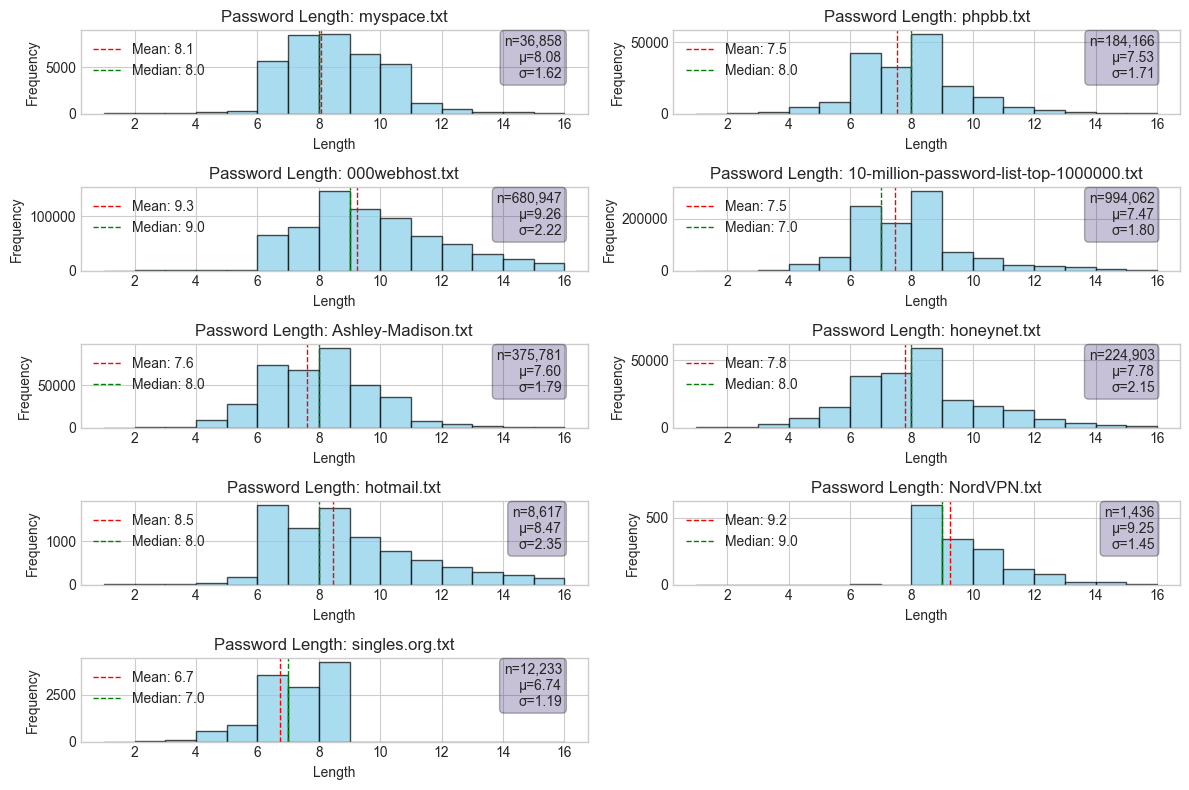

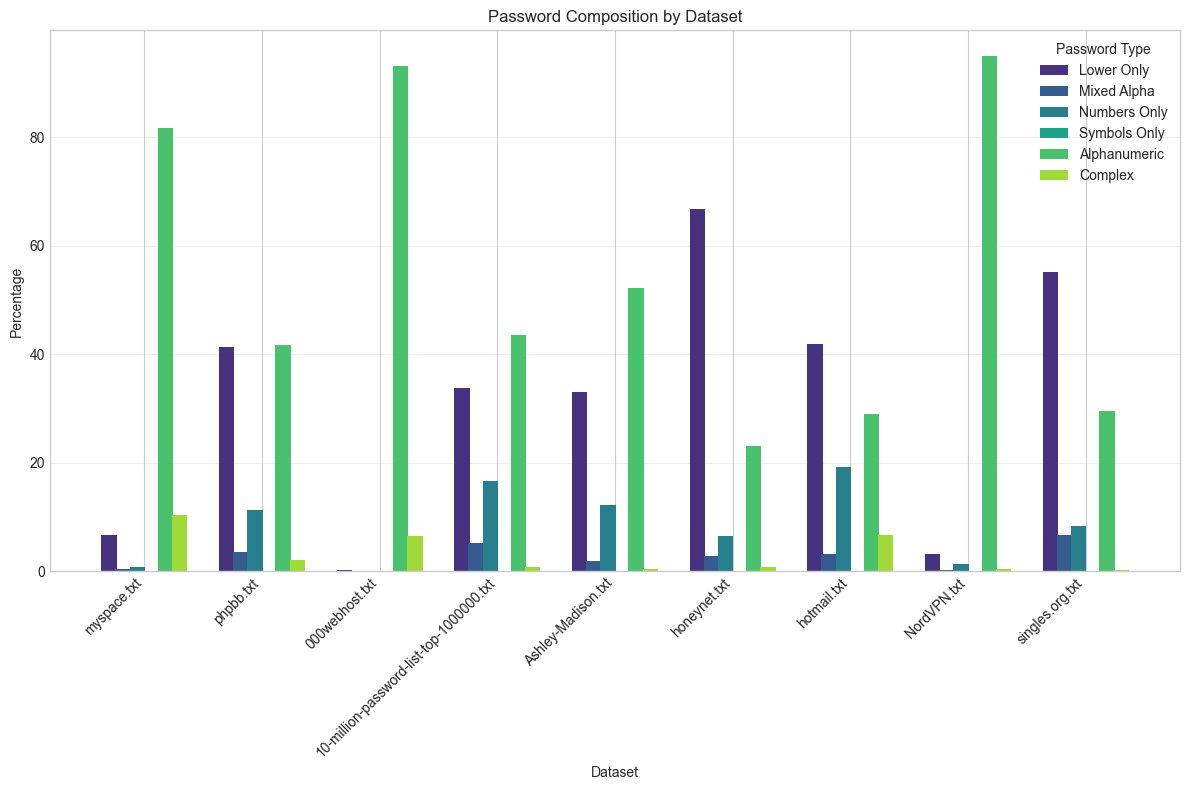


Summary Statistics:


,Dataset,Total,Filtered,Filter %,Avg Len,Median,StdDev,Lower Alpha %,Mixed Alpha %,Numeric %,Special %,Alphanum %,Complex %
0,myspace.txt,37126,36858,99.278134,8.076021,8.0,1.624439,6.638993,0.428672,0.724402,0.029844,81.713604,10.464485
1,phpbb.txt,184388,184166,99.879602,7.526357,8.0,1.711856,41.252457,3.614131,11.250176,0.032579,41.724314,2.126343
2,000webhost.txt,720302,680947,94.536319,9.255562,9.0,2.220983,0.174463,0.023350,0.070343,0.001028,93.153799,6.577017
3,10-million-password-list-top-1000000.txt,999998,994062,99.406399,7.468552,7.0,1.804948,33.752221,5.189415,16.608924,0.003320,43.580079,0.866043
4,Ashley-Madison.txt,375853,375781,99.980844,7.601744,8.0,1.787187,33.134459,1.850280,12.317813,0.003193,52.226962,0.467293
5,honeynet.txt,226081,224903,99.478948,7.779656,8.0,2.151615,66.811470,2.839891,6.459229,0.062694,23.061498,0.765219
6,hotmail.txt,8930,8617,96.494961,8.468957,8.0,2.353961,41.963560,3.260996,19.194615,0.011605,28.954392,6.614831
7,NordVPN.txt,1437,1436,99.930411,9.248607,9.0,1.448332,3.133705,0.208914,1.323120,0.000000,94.916435,0.417827
8,singles.org.txt,12233,12233,100.000000,6.740538,7.0,1.187294,55.105044,6.637783,8.370800,0.000000,29.632960,0.253413


In [26]:
# Define maximum password length
max_length = 15

# Define datasets to analyze
datasets = [
    '../datasets/myspace.txt',
    '../datasets/phpbb.txt',
    '../datasets/000webhost.txt',
    '../datasets/10-million-password-list-top-1000000.txt',
    '../datasets/Ashley-Madison.txt',
    '../datasets/honeynet.txt',
    '../datasets/hotmail.txt',
    '../datasets/NordVPN.txt', 
    '../datasets/singles.org.txt'
]

# Process all datasets
processed_data, all_stats = process_password_datasets(datasets)

In [27]:
def load_encoded_data(dataset_names, processed_dir=PROCESSED_DIR):
    """Load multiple encoded datasets and return a combined dataset"""
    all_data = []
    
    for name in dataset_names:
        file_path = os.path.join(processed_dir, f"{name}_encoded.npy")
        if os.path.exists(file_path):
            encoded_data = np.load(file_path)
            print(f"Loaded {name} encoded data: {encoded_data.shape}")
            all_data.append(encoded_data)
        else:
            print(f"Warning: {file_path} not found")
    
    if all_data:
        combined_data = np.concatenate(all_data, axis=0)
        print(f"Combined dataset shape: {combined_data.shape}")
        return combined_data
    else:
        print("No encoded data found.")
        return None

def prepare_training_data(encoded_data, seq_length=8, step=1, train_ratio=0.8, val_ratio=0.1):
    """Prepare training, validation and test sets for TCN model"""
    if encoded_data is None:
        return None, None, None
        
    # Create input-target pairs for sequence prediction
    X, y = [], []
    
    for i in range(0, len(encoded_data) - seq_length, step):
        X.append(encoded_data[i:i+seq_length-1])  # Input sequence (n-1 characters)
        y.append(encoded_data[i+seq_length-1])    # Target (next character)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created {len(X)} training sequences")
    print(f"Input shape: {X.shape}, Target shape: {y.shape}")
    
    # Split into train, validation and test sets
    total = len(X)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)
    
    # Create indices for random splitting
    indices = np.random.permutation(total)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]
    
    # Split data
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [28]:
# Load encoded data for model training
encoded_data = load_encoded_data(['myspace', 'honeynet'])

# Prepare data for TCN model
train_data, val_data, test_data = prepare_training_data(encoded_data)

# Save prepared data for model training
if train_data is not None:
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data
    
    # Save as numpy arrays for model training
    np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train)
    np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)
    np.save(os.path.join(PROCESSED_DIR, 'X_val.npy'), X_val)
    np.save(os.path.join(PROCESSED_DIR, 'y_val.npy'), y_val)
    np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test)
    np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)
    
    print("Saved prepared data for TCN model training")

No encoded data found.


In [29]:
# Next steps for TCN model implementation
print("## Password Guessing TCN Implementation Plan")
print("\n1. Build TCN model architecture")
print("   - Define dilated causal convolutions")
print("   - Set up residual blocks")
print("   - Configure input and output layers")
print("\n2. Implement training pipeline")
print("   - Define loss function and optimizer")
print("   - Set up training loop with validation")
print("   - Add early stopping and checkpointing")
print("\n3. Create evaluation metrics")
print("   - Character prediction accuracy")
print("   - Password match rate")
print("   - Perplexity metrics")
print("\n4. Implement password generation/guessing")
print("   - Add sampling methods")
print("   - Implement beam search for better guessing")
print("   - Create password strength evaluation")

## Password Guessing TCN Implementation Plan

1. Build TCN model architecture
   - Define dilated causal convolutions
   - Set up residual blocks
   - Configure input and output layers

2. Implement training pipeline
   - Define loss function and optimizer
   - Set up training loop with validation
   - Add early stopping and checkpointing

3. Create evaluation metrics
   - Character prediction accuracy
   - Password match rate
   - Perplexity metrics

4. Implement password generation/guessing
   - Add sampling methods
   - Implement beam search for better guessing
   - Create password strength evaluation


In [30]:
# Simple test to verify encoding and decoding works correctly
test_passwords = ['password123', 'P@ssw0rd!', 'qwerty', '123456', 'admin@site.com']
print("Testing encoding and decoding:\n")

for pwd in test_passwords:
    encoded = encode_password(pwd)
    decoded = decode_password(encoded)
    print(f"Original: {pwd}")
    print(f"Encoded shape: {encoded.shape}")
    print(f"Decoded: {decoded}")
    print(f"Match: {'✓' if pwd == decoded else '✗'}\n")

Testing encoding and decoding:

Original: password123
Encoded shape: (16, 4)
Decoded: password123
Match: ✓

Original: P@ssw0rd!
Encoded shape: (16, 4)
Decoded: P@ssw0rd!
Match: ✓

Original: qwerty
Encoded shape: (16, 4)
Decoded: qwerty
Match: ✓

Original: 123456
Encoded shape: (16, 4)
Decoded: 123456
Match: ✓

Original: admin@site.com
Encoded shape: (16, 4)
Decoded: admin@site.com
Match: ✓

